<a href="https://colab.research.google.com/github/wahyunirosyidah/Klasifikasi-Jenis-Jenis-Noken-Menggunakan-CNN/blob/main/imagenet_MobileNetV2_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from io import BytesIO
from ipywidgets import widgets

In [52]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/SKRIPSI AYU'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SKRIPSI AYU


In [53]:
# Directory Path
BASE_DIR = 'Dataset Binary'
print(f"Base Directory: {os.listdir(BASE_DIR)}")

data_train=f'{BASE_DIR}/train'
print(f"Train Directory: {sorted(os.listdir(data_train))}")
data_validation=f'{BASE_DIR}/valid'
print(f"Valid Directory: {sorted(os.listdir(data_validation))}")

Base Directory: ['train', 'valid']
Train Directory: ['Bitu Agia', 'Junum Ese']
Valid Directory: ['Bitu Agia', 'Junum Ese']


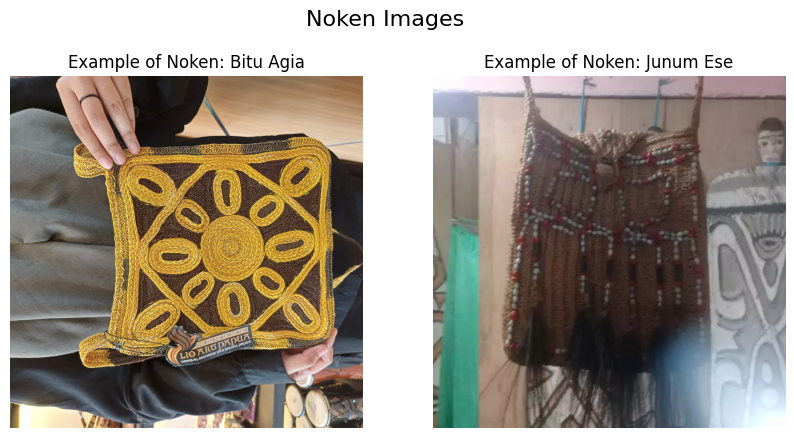

In [54]:
# Plot noken Images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Noken Images', fontsize=16)

# List of noken
noken_list = os.listdir(data_train)
# Plot images for each noken
for i, noken in enumerate(noken_list):
    dir_path = f'{data_train}/{noken}'
    img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
    # row, col = divmod(i, 3)
    axes[i].imshow(img)
    axes[i].set_title(f'Example of Noken: {noken}')
    axes[i].axis('off')

# Disable axis on empty subplots if any
for jj in range(len(noken_list), 9):
    row, col = divmod(jj, 3)
    axes[i].axis('off')

plt.show()

In [55]:
BATCH_SIZE=32
IMAGE_SIZE=224
LABEL_MODE='binary'

# # Inisiasi Dataset
# train_dataset,validation_dataset=tf.keras.utils.image_dataset_from_directory(
#     data_train,
#     image_size=(IMAGE_SIZE,IMAGE_SIZE),
#     batch_size=BATCH_SIZE,
#     label_mode=LABEL_MODE,
#     validation_split=0.2, #20% data untuk validasi
#     subset='both',
#     seed=42
# )

# Prepare the training set
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE,
    seed=42
    )

# Prepare the validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_validation,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE,
    seed=42
    )

Found 400 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [56]:
#Optimasi
SHUFFLE_BUFFER_SIZE=500
PREFETCH_BUFFER_SIZE=tf.data.AUTOTUNE

train_dataset_final=(
    train_dataset
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

validation_dataset_final=(
    validation_dataset
    .cache()
    .prefetch(PREFETCH_BUFFER_SIZE)
)

In [57]:
FILL_MODE='reflect'

data_augmentation=tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
])

In [58]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet'
                                               )
base_model.trainable = False

In [59]:
#create model
def create_model():
    model=tf.keras.models.Sequential([
        data_augmentation,
        base_model,
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    return model

In [60]:
model = create_model()
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,286,401 (39.24 MB)

 Trainable params: 8,028,417 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [61]:
# Constant for epochs
EPOCHS = 50

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Train the model
history = model.fit(
    train_dataset_final,
    epochs=EPOCHS,
    validation_data=validation_dataset_final,
    verbose=1
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.6771 - loss: 0.8033 - val_accuracy: 0.9700 - val_loss: 0.0882
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8789 - loss: 0.3696 - val_accuracy: 1.0000 - val_loss: 0.0327
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9096 - loss: 0.1938 - val_accuracy: 1.0000 - val_loss: 0.0266
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9223 - loss: 0.1983 - val_accuracy: 0.9600 - val_loss: 0.0729
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9682 - loss: 0.0997 - val_accuracy: 0.9400 - val_loss: 0.1169
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9521 - loss: 0.1275 - val_accuracy: 0.9900 - val_loss: 0.0239
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9732 - loss: 0.0623 - val_accuracy: 0.9900 - val_loss: 0.0232
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9809 - loss: 0.0677 - val_accuracy: 0.9900 - val_loss:

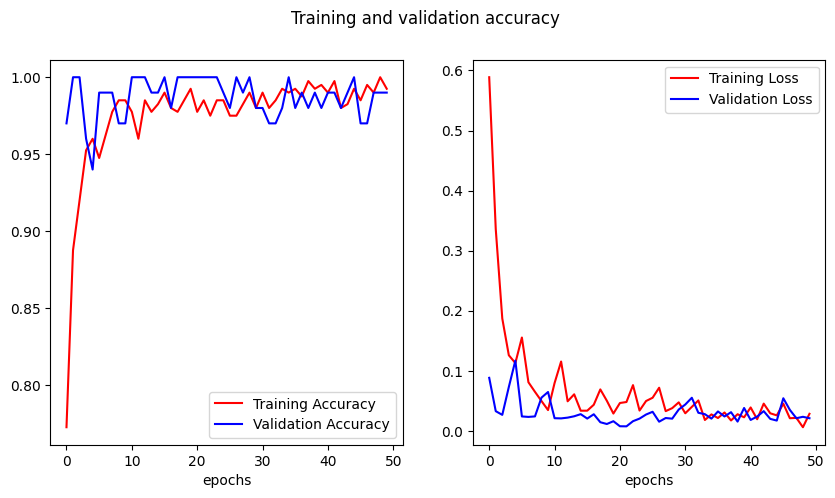

In [62]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [68]:
# Hitung jumlah file di dataset validasi
num_test_files = sum([len(files) for _, _, files in os.walk(data_validation)])
num_test_steps = num_test_files // BATCH_SIZE  # Total batch yang akan dievaluasi

# Evaluasi model
loss, acc = model.evaluate(validation_dataset_final, steps=num_test_steps, verbose=1)

print(f"Validation Loss: {loss * 100:.2f} %")
print(f"Validation Accuracy: {acc * 100:.2f} %")


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9909 - loss: 0.0182
Validation Loss: 2.19 %
Validation Accuracy: 98.96 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


<ipython-input-77-283336adc48e>:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


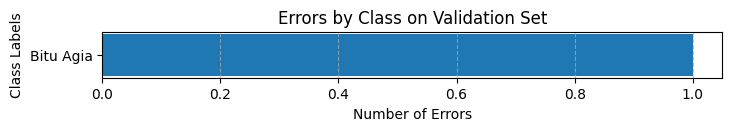

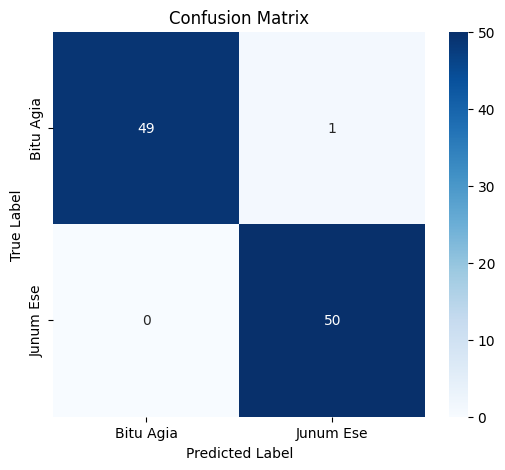

Classification Report:
              precision    recall  f1-score   support

   Bitu Agia       1.00      0.98      0.99        50
   Junum Ese       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

class_names = validation_dataset.class_names

# Evaluasi Model
y_true = []
y_pred = []

for images, labels in validation_dataset_final:
    preds = model.predict(images)
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend((preds > 0.5).astype(int).flatten())

# Konversi ke numpy array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Hitung error per kelas
errors_per_class = conf_matrix.sum(axis=1) - np.diag(conf_matrix)

# Filter hanya kelas yang memiliki error
filtered_labels = [label for label, errors in zip(class_names, errors_per_class) if errors > 0]
filtered_errors = [errors for errors in errors_per_class if errors > 0]

# Errors by Class
if len(filtered_labels) > 0:
    colors = plt.cm.tab10(np.linspace(0, 1, len(filtered_labels)))

    plt.figure(figsize=(8, len(filtered_labels) * 0.6))
    plt.barh(filtered_labels, filtered_errors, color=colors)
    plt.title('Errors by Class on Validation Set', fontsize=12)
    plt.xlabel('Number of Errors', fontsize=10)
    plt.ylabel('Class Labels', fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada kelas yang memiliki error!")

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


